# Importing libraries

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf

# Loading images
We will use Drive dataset that is available: https://www.kaggle.com/datasets/zionfuo/drive2004/


In [2]:
# helper function for reading image
def read_images(path):
    directory = path
    files = glob.glob(directory+'*')

    dataset = []
    for image_path in files:
        image = tf.keras.utils.load_img(image_path)
        dataset.append(image)
    return dataset

In [3]:
train_image_dataset = read_images('C:/Users/Narjes/Desktop/vessel Segmentation/DRIVE/training/images/')
train_mask_dataset = read_images('C:/Users/Narjes/Desktop/vessel Segmentation/DRIVE/training/1st_manual/')
test_image_dataset = read_images('C:/Users/Narjes/Desktop/vessel Segmentation/DRIVE/test/images/')
test_mask_dataset = read_images('C:/Users/Narjes/Desktop/vessel Segmentation/DRIVE/test/1st_manual/')

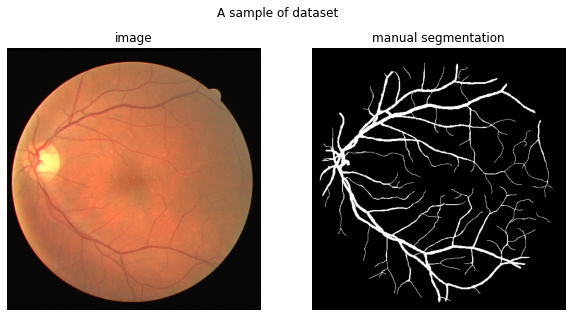

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image_dataset[0])
ax[0].set_title('image')
ax[0].axis('off')
ax[1].imshow(train_mask_dataset[0])
ax[1].set_title('manual segmentation')
ax[1].axis('off')
fig.suptitle('A sample of dataset')
plt.show()

# Pre-processing
Every image is resized to the standard size of [512,512,3] and then normalized to the range of [0,1].

In [5]:
def preprocessing(image,size,method):
    resized_image = tf.image.resize(image, size, method)
    normalized_image = tf.cast(resized_image, tf.float32) / 255.0
    return normalized_image

In [6]:
size = (512,512)
train_image_dataset = list(map(lambda image: preprocessing(image, size , 'nearest'), train_image_dataset))
train_mask_dataset = list(map(lambda image: preprocessing(image, size , 'nearest'), train_mask_dataset))
test_image_dataset = list(map(lambda image: preprocessing(image, size , 'nearest'), test_image_dataset))
test_mask_dataset = list(map(lambda image: preprocessing(image, size , 'nearest'), test_mask_dataset))

# Augmentations

Since the dataset is small we will employ the data augmentation techniques to increase the amount of data. The following data augmentations will be utilized:

- horizontal flip
- brightness change
- gaussian noise addition


In [7]:
# helper function for image augmentation
def augment(image, mask):
    augmented_images = []
    augmented_masks = []

    # Horizontal flip
    flipped_image = tf.image.flip_left_right(image)
    flipped_mask = tf.image.flip_left_right(mask)
    augmented_images.append(flipped_image)
    augmented_masks.append(flipped_mask)

    # Brightness change
    brightened_image = tf.image.random_brightness(image, max_delta=0.8)
    augmented_images.append(brightened_image)
    augmented_masks.append(mask)  # Keeping the mask unchanged for brightness change
    
    # Add Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1)
    noisy_image = tf.clip_by_value(image + noise, 0.0, 1.0) 
    augmented_images.append(noisy_image)
    augmented_masks.append(mask)  # Keeping the mask unchanged
    
    return augmented_images, augmented_masks

In [8]:
from itertools import chain
augmented_data = list(map(augment, train_image_dataset, train_mask_dataset))
augmented_images, augmented_masks = zip(*augmented_data)
train_image_dataset.extend(list(chain(*augmented_images))) 
train_mask_dataset.extend(list(chain(*augmented_masks))) 

### Divide images to patches

In [9]:
def extract_patches(image, patch_size, strides):
    # Reshape the image into a batch with shape [1, height, width, channels] to make it compatible with 'tf.image.extract_patches'
    image = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Divide the image into patches
    patches = tf.image.extract_patches(image, sizes=[1,*patch_size,1], strides=strides, rates=[1,1,1,1], padding='VALID')
    # Reshape the patches to individual patches
    patches = tf.reshape(patches, [-1, patch_size[0], patch_size[1], image.shape[-1]])
    # # Split into a list 
    patches = tf.unstack(patches)
    
    return patches
          

In [10]:
patch_size = (128, 128)
image_patches = list(map(lambda image:extract_patches(image, patch_size, [1,patch_size[0]/4,patch_size[1]/4,1]),train_image_dataset))
mask_patches = list(map(lambda image:extract_patches(image, patch_size, [1,patch_size[0]/4,patch_size[1]/4,1]),train_mask_dataset))

train_image_patches = tf.concat(image_patches, axis=0)
train_mask_patches = tf.concat(mask_patches, axis=0)

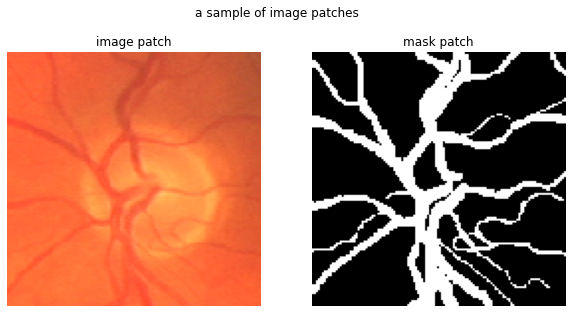

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].imshow(train_image_patches[400])
ax[0].set_title('image patch')
ax[0].axis("off")

ax[1].imshow(train_mask_patches[400])
ax[1].set_title('mask patch')
ax[1].axis("off")

fig.suptitle('a sample of image patches')
plt.show()

# Building the U-net

In [12]:
# helper functions for building Unet
def conv_block(inputs, n_filter, kernel_size=3, activation_f='relu'):
    x = tf.keras.layers.Conv2D(filters=n_filter, kernel_size=kernel_size, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_f)(x)
    x = tf.keras.layers.Conv2D(filters=n_filter,kernel_size=kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation_f)(x)
    
    return x

def encoder_block(inputs, n_filter):
    x = conv_block(inputs, n_filter)
    x = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(x)
    return x

def decoder_block(inputs,skip_connection, n_filter):
    x = tf.keras.layers.Conv2DTranspose(filters=n_filter,kernel_size=3,strides=2,padding='same',activation='relu')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_connection])
    x = conv_block(x, n_filter)
    return x

In [13]:
# Unet model
im_shape = train_image_patches[0].shape
n_filter = 8

# Encoder
input_layer = tf.keras.layers.Input(shape=im_shape)

skip1 = conv_block(input_layer, n_filter)
pool1 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(skip1)

skip2 = conv_block(pool1, n_filter*2)
pool2 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(skip2)

skip3 = conv_block(pool2, n_filter*4)
pool3 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(skip3)

layer4 = conv_block(pool3, n_filter*8)

# Decoder
decode1 = decoder_block(layer4,skip3, n_filter*4)
decode2 = decoder_block(decode1,skip2, n_filter*2)
decode3 = decoder_block(decode2,skip1, n_filter)
outputs = tf.keras.layers.Conv2D(filters=3,kernel_size=1,padding='same',activation='sigmoid')(decode3)

Unet =tf.keras.Model(inputs=input_layer, outputs=outputs)

# Training the model

In [16]:
# compiling the model
from tensorflow.keras.metrics import  Precision, Recall
Unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             loss='binary_crossentropy',
             metrics=[ Precision(), Recall()])

In [19]:
# Training the model on the Training set and evaluating it on the validation set
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
Unet.fit(train_image_patches, train_mask_patches, validation_split=.2, batch_size=64, epochs=50, callbacks=[early_stopping])

Epoch 1/50
169/169 [==============================] - 400s 2s/step - loss: 0.0933 - precision_1: 0.8669 - recall_1: 0.7846 - val_loss: 0.1873 - val_precision_1: 0.8172 - val_recall_1: 0.6282
Epoch 2/50
169/169 [==============================] - 400s 2s/step - loss: 0.0930 - precision_1: 0.8664 - recall_1: 0.7863 - val_loss: 0.1803 - val_precision_1: 0.7833 - val_recall_1: 0.6626
Epoch 3/50
169/169 [==============================] - 400s 2s/step - loss: 0.0921 - precision_1: 0.8682 - recall_1: 0.7867 - val_loss: 0.1949 - val_precision_1: 0.8318 - val_recall_1: 0.6200
Epoch 4/50
169/169 [==============================] - 399s 2s/step - loss: 0.0911 - precision_1: 0.8686 - recall_1: 0.7898 - val_loss: 0.1860 - val_precision_1: 0.7495 - val_recall_1: 0.6863
Epoch 5/50
169/169 [==============================] - 441s 3s/step - loss: 0.0907 - precision_1: 0.8690 - recall_1: 0.7902 - val_loss: 0.1822 - val_precision_1: 0.7831 - val_recall_1: 0.6635
Epoch 6/50
169/169 [=========================

# Segmentation of test images

In [20]:
patch_size = (128, 128)
num_patch_c = int(test_image_dataset[0].shape[0]/patch_size[0])
num_patch_r = int(test_image_dataset[0].shape[1]/patch_size[1])

# Compute precision and recall
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

y_pred = []
test_precision = []
test_recall = []
for i in range(len(test_image_dataset)):
    # Divide each test image to patches
    image_patches_t = extract_patches(test_image_dataset[i], patch_size, [1,patch_size[0],patch_size[1],1])
    test_im = tf.stack(image_patches_t)
    
    # segmentation of each patch
    y_pred_patches = Unet.predict(test_im, verbose=0)
    
    # segmentation result of test image
    y_pred_t = np.concatenate(np.concatenate(np.array(y_pred_patches).reshape((num_patch_c, num_patch_r, patch_size[0], patch_size[1], 3)), axis=1), axis=1)
    y_pred.append(y_pred_t)
    
    # Update metrics with the ground truth and segmentation result
    precision.update_state(test_mask_dataset[i], y_pred_t)
    recall.update_state(test_mask_dataset[i], y_pred_t)

    # Get the current values of precision and recall
    current_precision = precision.result().numpy()
    current_recall = recall.result().numpy()
    
    test_precision.append(current_precision)
    test_recall.append(current_recall)
    
    # Reset the states of the metrics for the next batch
    precision.reset_states()
    recall.reset_states()
    
    # Print the precision and recall values for each test image
    print("test image",i,"==> " "Precision:", current_precision, "Recall:", current_recall)

test image 0 ==> Precision: 0.77222955 Recall: 0.79474103
test image 1 ==> Precision: 0.84732455 Recall: 0.77879465
test image 2 ==> Precision: 0.8667716 Recall: 0.63436115
test image 3 ==> Precision: 0.8480083 Recall: 0.74819624
test image 4 ==> Precision: 0.87358296 Recall: 0.6887618
test image 5 ==> Precision: 0.85968345 Recall: 0.6831766
test image 6 ==> Precision: 0.84825265 Recall: 0.713698
test image 7 ==> Precision: 0.8278471 Recall: 0.6727868
test image 8 ==> Precision: 0.8586679 Recall: 0.6485028
test image 9 ==> Precision: 0.81372887 Recall: 0.7333643
test image 10 ==> Precision: 0.7919666 Recall: 0.74133754
test image 11 ==> Precision: 0.8119279 Recall: 0.7670784
test image 12 ==> Precision: 0.8446547 Recall: 0.71596634
test image 13 ==> Precision: 0.78493017 Recall: 0.7949811
test image 14 ==> Precision: 0.7482507 Recall: 0.8139829
test image 15 ==> Precision: 0.8422834 Recall: 0.7429191
test image 16 ==> Precision: 0.83883303 Recall: 0.6668314
test image 17 ==> Precision:

In [21]:
print("test images evaluation ==> " "test_precision:", np.mean(test_precision) , "test_recall:", np.mean(test_recall))

test images evaluation ==> test_precision: 0.81976587 test_recall: 0.73860013


# Segmentation result of a sample test image

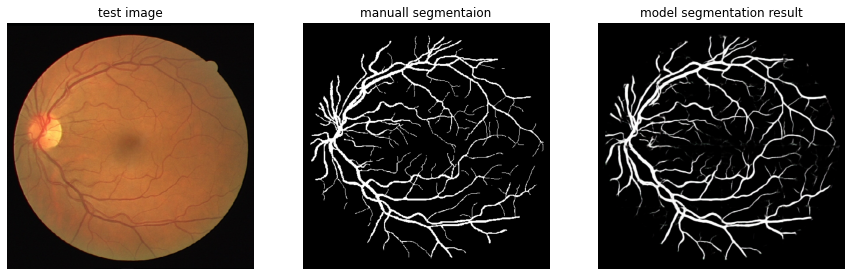

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15, 10))
ax[0].axis("off")
ax[0].imshow(test_image_dataset[0])
ax[0].set_title("test image")
ax[1].axis("off")
ax[1].imshow(test_mask_dataset[0])
ax[1].set_title("manuall segmentaion")
ax[2].axis("off")
ax[2].imshow((y_pred[0]))
ax[2].set_title("model segmentation result")
plt.show()